In [1]:
from llm_recommendation_proxy.router import Router
from pprint import pp
from copy import deepcopy
from openai import OpenAI
from functools import cache
import os
import json
import numpy as np
import pickle
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%load_ext autoreload
%autoreload 2

## Load example data

We use synthetic data to illustrate the data used in this study. In the below code chunk, `requests` is a list containing information as dictionaries like:

```
requests[i] = {'tutor_id': 'math-parent-tool',
  'KC': ['subtraction-const', 'cancel-var'],
  'chat_history': ['Student: I did this wrong. I am not sure where i messed up',
                   'Caregiver: ...',
                   ... ] # more multiturn conversation between student and caregiver
  'curr_question': '4x-10=-x+10',
  'correct_step_history': '5x-10 = 10',
  'incorrect_step_history': '3x-10 = 10',
  'hints': [],
  'next_steps': ['5x = 20', 'x = 4']},
```

In [ ]:
def read_jsonl(file_path):
    data_list = []
    with open(file_path, 'r') as file:
        for line in file:
            data_list.append(json.loads(line.strip()))  # Remove leading/trailing spaces and parse each line as JSON
    return data_list

def dump_to_jsonl(data_list, file_path):
    with open(file_path, 'w') as file:
        for item in data_list:
            file.write(json.dumps(item) + '\n')

requests = read_jsonl('test-data/mock_requests.json')
pp(requests)

The code chunk below are utility functions used for tutoring training classifier proposed by Thomas et al. (Danielle Thomas, Xinyu Yang, Shivang Gupta, Adetunji Adeniran, Elizabeth Mclaughlin, and Kenneth Koedinger. 2023. When the Tutor Becomes the Student: Design and Evaluation of Efficient Scenario-based Lessons for Tutors. In LAK23: 13th International Learning Analytics and Knowledge Conference (LAK2023). Association for Computing Machinery, New York, NY, USA, 250–261. https://doi.org/10.1145/3576050.3576089).

The scoring prompts below are adapted from work by Thomas et al. (Thomas, D. R., Borchers, C., Kakarla, S., Lin, J., Bhushan, S., Guo, B., Gatz, E., & Koedinger, K. R. (2024). Do tutors learn from equity training and can generative AI assess it? [Preprint]. arXiv. https://doi.org/10.48550/arXiv.2412.11255).

In [9]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def rateErrorReactions(recs: list[str]):
    SCORING_PROMPT_START = \
"""
You are a tutor evaluator. Please score the following tutor response to a tutor training scenario involving a middle school student as follows:

-If the tutor’s response provides an implicit way of calling attention to the error, focus on encouraging students thinking about math and  metacognition rather than giving explicit answers, and use effective praise to motivate students' learning, score with a 1. Examples of responses scoring a 1 are: “Lucy, great start! Explain how you passed to the second column.”; “Thank you for showing me your work, Lucy. You worked hard on adding these numbers. I am going to work on this problem with you. Can you tell me how you added the numbers first?”; “Well done setting up the problem, Lucy. Can you tell me how you went about calculating the first few steps?”; “I like your effort, but show me what you are trying to do in the second step.”; “Kanye, very well done. Your effort was very valuable. Can you repeat how you arrived at this result? Let's do this problem together.”

-If the tutor's response directly addresses the student’s error using explicit language, or directly calls attention to the student’s error, or fails to encourage the students think about math or metacognition by not guiding them to reflect on their thought process, score with a 0.
Sample responses scoring a 0 include: “Let's try solving the problem together.”; “Good effort.”; “I got a different answer. Let's look at this together.”; “Do you know about carrying the 1?”; “Kanye, let me show you how this should be done.”

Response Start ---
"""

    SCORING_FORMAT_PROMPT = \
"""
--- Response End. Given the earlier response, please return a JSON string following the format, {"Rationale": "your reasoning here", "Score":0/1}.
"""

    scores = []
    for rec in recs:
        overall_history = [{"role": "system", "content": SCORING_PROMPT_START}, {"role": "user", "content": rec}, {"role": "system", "content": SCORING_FORMAT_PROMPT}]
        openai_out = client.chat.completions.create(model="gpt-3.5-turbo", messages=overall_history, max_tokens=300, temperature=0)
        response_data = json.loads(openai_out.choices[0].message.content)
        score = response_data["Score"]
        scores.append(score)
        
    return scores

def ratePraises(recs: list[str]):
    SCORING_PROMPT_START = \
"""
You are a tutor evaluator. Please score the following tutor response to a tutor training scenario involving a middle school student as follows:

-if the tutor’s response provides effective, process-focused praise that acknowledges the student’s effort, hard work, perseverance, or focuses on the student’s actions towards the learning process, score with a 1. Examples of responses scoring a 1 are: “Kevin, you didn't give up and you managed to learn, congratulations! Let's finish your math homework together so you can still get a good grade and learn how this kind of homework will be easier sooner.”; “Keep Working.”; “Great job Kevin! You are on the right track, keep working on the problem, you get it!”; “Kevin, that was awesome the way you kept at it and were able to get to the correct answer. You should be proud. Keep up the great work!”; “You're doing a great job working on this paragraph! It can be tricky to find the right words and I think you're doing really well working through it.”

-if the tutor's response provides outcomes-based praise, acknowledging only the student’s achievements or outcomes, or does not acknowledge the learning process or effort towards learning, score with a 0. Sample responses scoring a 0 include: “You\'re doing great, let\'s see what the next step is.”; “Good Job.”; “I would say she is doing well and let us explore a bit more.”; “I think you are doing great.”; “You can do this! Just take it one step at a time.”

Response Start ---
"""

    SCORING_FORMAT_PROMPT = \
"""
--- Response End. Given the earlier response, please return a JSON string following the format, {"Rationale": "your reasoning here", "Score":0/1}.
"""
    scores = []
    for rec in recs:
        overall_history = [{"role": "system", "content": SCORING_PROMPT_START}, {"role": "user", "content": rec}, {"role": "system", "content": SCORING_FORMAT_PROMPT}]
        openai_out = client.chat.completions.create(model="gpt-3.5-turbo", messages=overall_history, max_tokens=300, temperature=0)
        response_data = json.loads(openai_out.choices[0].message.content)
        score = response_data["Score"]
        scores.append(score)
        
    return scores

def evalResponses(requests: list[dict], responses: list[str], prompts: list[str]) -> list[dict]:
    evalResult = list()
    for request, response, prompt in zip(requests, responses, prompts):
        entry = dict()
        entry['response'] = response
        entry['prompt'] = prompt
        entry['has_intention'] = '[' in response and ']' in response
        entry['has_delimiter'] = '#' in response
        entry['has_three_recommendations'] = entry['has_delimiter'] and len(response.split('#')) == 3
        entry['has_no_prefix'] = response.strip().startswith('[')
        if not request['incorrect_step_history']:
            entry['praise_ratings'] = ratePraises(response.split('#'))
        else:
            entry['error_reaction_ratings'] = rateErrorReactions(response.split('#'))
        
        evalResult.append(entry)
        
    report = dict()
    for entry in evalResult:
        for key in entry.keys():
            if key not in report: report[key] = [0, 0]
            if isinstance(entry[key], bool):
                report[key][0] += int(entry[key])
                report[key][1] += 1
            elif 'ratings' in key:
                report[key][0] += sum(entry[key])
                report[key][1] += len(entry[key])
    print("*** Recommendation quality evaluation report: ***")
    pp(report)
    
    return evalResult
        

For the three code chunks below, we prompt the three models with the prompts generated from previously loaded context examples. These responses are then rated by the tutor training classifier, leading to the results reported in Table 2 in the manuscript. 

In [ ]:
# GPT-4o responses for raw requests
router = Router()
responses = []
prompts = []
for request in requests:
    request = deepcopy(request)
    request["model_id"] = "GPT-4o"
    response, prompt = router.processRequest(request, mode="test")
    responses.append(response)
    prompts.append(prompt)
    
dump_to_jsonl(evalResponses(requests, responses, prompts), 'test-data/gpt-4o-responses.jsonl')

In [ ]:
# Llama3-8B responses for raw requests
router = Router()
responses = []
prompts = []
for request in requests:
    request = deepcopy(request)
    request["model_id"] = "Llama3-8B"
    response, prompt = router.processRequest(request, mode="test")
    responses.append(response)
    prompts.append(prompt)
    
dump_to_jsonl(evalResponses(requests, responses, prompts), 'test-data/llama3-8b-responses.jsonl')

In [ ]:
# Llama3-70B responses for raw requests
router = Router()
responses = []
prompts = []
for request in requests:
    request = deepcopy(request)
    request["model_id"] = "Llama3-70B"
    response, prompt = router.processRequest(request, mode="test")
    responses.append(response)
    prompts.append(prompt)
    
dump_to_jsonl(evalResponses(requests, responses, prompts), 'test-data/llama3-70b-responses.jsonl')

GPT-4o quality report:
*** Recommendation quality evaluation report: ***
{'has_intention': [75, 75],
 'has_delimiter': [75, 75],
 'has_three_recommendations': [75, 75],
 'has_no_prefix': [75, 75],
 'praise_ratings': [102, 153],
 'error_reaction_ratings': [40, 72]}
 
Llama3-8B quality report:
*** Recommendation quality evaluation report: ***
{'has_intention': [71, 75],
 'has_delimiter': [31, 75],
 'has_three_recommendations': [26, 75],
 'has_no_prefix': [64, 75],
 'praise_ratings': [75, 94],
 'error_reaction_ratings': [28, 40]}

Llama3-70B quality report:
*** Recommendation quality evaluation report: ***
{'response': [0, 0],
 'prompt': [0, 0],
 'has_intention': [73, 75],
 'has_delimiter': [73, 75],
 'has_three_recommendations': [72, 75],
 'has_no_prefix': [72, 75],
 'praise_ratings': [104, 150],
 'error_reaction_ratings': [34, 72]}

## Evaluate responsiveness

We then proceed to analysis on LLMs' responsiveness typical to ITS as described in sections 2.5 and 2.6. To begin with, we first define the routine to conduct context variation:

In [3]:
def variateRequest(request: dict) -> tuple[list[str], list[dict]]:
    variants = [request]
    
    reqWithoutCorrectSteps = deepcopy(request)
    reqWithoutCorrectSteps["correct_step_history"] = []
    variants.append(reqWithoutCorrectSteps)
    
    reqWithoutIncorrectSteps = deepcopy(request)
    reqWithoutIncorrectSteps["incorrect_step_history"] = []
    variants.append(reqWithoutIncorrectSteps)
    
    reqWithoutNextSteps = deepcopy(request)
    reqWithoutNextSteps["next_steps"] = []
    variants.append(reqWithoutNextSteps)
    
    reqWithoutKC = deepcopy(request)
    reqWithoutKC["KC"] = []
    variants.append(reqWithoutKC)
    
    reqWithoutHints = deepcopy(request)
    reqWithoutHints["hints"] = []
    variants.append(reqWithoutHints)
    
    return ["raw", "lack_correct_steps", "lack_incorrect_steps", "lack_next_steps", "lack_kc", "lack_hints"], variants

We then prompt the three models with contexts after variation. These generation are then saved to local json files for further analysis. These files are also manually examined to produce results presented in section 3.3.

In [ ]:
# GPT-4o responses for responsiveness tester requests
router = Router()
responseGroups = []
for request in requests:
    request = deepcopy(request)
    request["model_id"] = "GPT-4o"
    variantTypes, variants = variateRequest(request)
    group = dict()
    for vType, v in zip(variantTypes, variants):
        response = router.processRequest(v, mode="test")[0]
        group[vType] = response
    
    responseGroups.append(group)
    
dump_to_jsonl(responseGroups, 'test-data/gpt-4o-responsiveness-v2.jsonl')

In [ ]:
# Llama3-8B responses for responsiveness tester requests
router = Router()
responseGroups = []
for request in requests:
    request = deepcopy(request)
    request["model_id"] = "Llama3-8B"
    variantTypes, variants = variateRequest(request)
    group = dict()
    for vType, v in zip(variantTypes, variants):
        response = router.processRequest(v, mode="test")[0]
        group[vType] = response
    
    responseGroups.append(group)
    
dump_to_jsonl(responseGroups, 'test-data/llama3-8b-responsiveness-v2.jsonl')

In [ ]:
# Llama3-70B responses for responsiveness tester requests
router = Router()
responseGroups = []
for request in requests:
    request = deepcopy(request)
    request["model_id"] = "Llama3-70B"
    variantTypes, variants = variateRequest(request)
    group = dict()
    for vType, v in zip(variantTypes, variants):
        response = router.processRequest(v, mode="test")[0]
        group[vType] = response
    
    responseGroups.append(group)
    
dump_to_jsonl(responseGroups, 'test-data/llama3-70b-responsiveness-v2.jsonl')

Now we have obtained LLM generations for variant contexts, we define the following helper routines to obtain sentence embedding and conduct statistical testing (section 2.5). Notice that the main mathematical procedure described in section 2.5 can be found in the `permutation_test()` function below.

In [5]:
@cache
def getEmbedding(text, model="text-embedding-3-large"):
    return np.array(client.embeddings.create(input=text, model=model, encoding_format="float").data[0].embedding)

def assessCosSimilarity(matrix1, matrix2):
    dot_product = np.sum(matrix1 * matrix2, axis=1)
    norm1 = np.linalg.norm(matrix1, axis=1)
    norm2 = np.linalg.norm(matrix2, axis=1)
    cosine_similarities = dot_product / (norm1 * norm2)
    return cosine_similarities

def assessEuclideanDistance(matrix1, matrix2):
    distances = np.sum((matrix1 - matrix2) ** 2, axis=1) ** 0.5
    return distances
    
def permutation_test(matrix1, matrix2, n_permutations=1000, metric='euclidean', seed=None):
    if seed is not None:
        np.random.seed(seed)
    combined = np.vstack((matrix1, matrix2))
    obs_stat = np.mean(cdist(matrix1, matrix2, metric=metric))
    
    perm_stats = []

    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_group1 = combined[:len(matrix1)]
        perm_group2 = combined[len(matrix1):]
        
        perm_stat = np.mean(cdist(perm_group1, perm_group2, metric=metric))
        perm_stats.append(perm_stat)

    perm_stats = np.array(perm_stats)
    p_value = np.mean(perm_stats >= obs_stat)
    effect_size = (obs_stat - np.mean(perm_stats)) / np.std(perm_stats)
    
    print("Permutation test summary:")
    print(f"p-value = {p_value}")
    print(f"effect size = {effect_size}")
    print(f"Observed test statistic = {obs_stat}")
    
def permutation_test_report(embeddingGroups: dict, group1: str, group2: str, metric: str):
    print(f"*** Permutation test report between {group1} and {group2}; metric = {metric} ***")
    permutation_test(embeddingGroups[group1], embeddingGroups[group2], metric=metric, seed=42)

def assessResponsiveness(jsonlFilePath: str):
    data = read_jsonl(jsonlFilePath)
    embeddingGroups = dict()
    for line in data:
        for key in line:
            if key not in embeddingGroups:
                embeddingGroups[key] = getEmbedding(line[key])
            else:
                embeddingGroups[key] = np.vstack((embeddingGroups[key], getEmbedding(line[key])))
                
    keys = set(embeddingGroups.keys())
    keys.remove("raw")
    for k in keys:
        cosineSimilarity = assessCosSimilarity(embeddingGroups['raw'], embeddingGroups[k])
        eucDistance = assessEuclideanDistance(embeddingGroups['raw'], embeddingGroups[k])
        print(f"Average cosine similarity between original responses and {k} (mean, std): {cosineSimilarity.mean(), cosineSimilarity.std()}")
        print(f"Average euclidean distance between original responses and {k} (mean, std): "
              f"{cosineSimilarity.mean(), cosineSimilarity.std()}")
    
    return embeddingGroups


We obtain the embedding vector through the `assessResponsiveness` routine, and conduct statistical testing to obtain the results in table 1.

In [6]:
embeddingGroups = assessResponsiveness("test-data/gpt-4o-responsiveness-v2.jsonl")
with open("test-data/gpt-4o-embeddings-v2.pkl", "wb") as file:
    pickle.dump(embeddingGroups, file)

with open("test-data/gpt-4o-embeddings-v2.pkl", "rb") as file:
    embeddingGroups = pickle.load(file)

In [ ]:
permutation_test_report(embeddingGroups, "raw", "lack_incorrect_steps", "cosine")
permutation_test_report(embeddingGroups, "raw", "lack_correct_steps", "cosine")
permutation_test_report(embeddingGroups, "raw", "lack_next_steps", "cosine")
permutation_test_report(embeddingGroups, "raw", "lack_hints", "cosine")
permutation_test_report(embeddingGroups, "raw", "lack_kc", "cosine")

*** Permutation test report between raw and lack_incorrect_steps; metric = cosine ***
Permutation test summary:
p-value = 0.293
effect size = 0.33376539136559175
Observed test statistic = 0.36230536893481025

*** Permutation test report between raw and lack_correct_steps; metric = cosine ***
Permutation test summary:
p-value = 0.995
effect size = -1.6586528530972622
Observed test statistic = 0.345359725751045

*** Permutation test report between raw and lack_next_steps; metric = cosine ***
Permutation test summary:
p-value = 0.999
effect size = -1.675421824371236
Observed test statistic = 0.3508862006414789

*** Permutation test report between raw and lack_hints; metric = cosine ***
Permutation test summary:
p-value = 1.0
effect size = -2.164320111282954
Observed test statistic = 0.34896716730660776

*** Permutation test report between raw and lack_kc; metric = cosine ***
Permutation test summary:
p-value = 0.998
effect size = -1.902855526566746
Observed test statistic = 0.35479692058624535

In [9]:
embeddingGroups = assessResponsiveness("test-data/llama3-8b-responsiveness-v2.jsonl")
with open("test-data/llama3-8b-embeddings-v2.pkl", "wb") as file:
    pickle.dump(embeddingGroups, file)
    
with open("test-data/llama3-8b-embeddings-v2.pkl", "rb") as file:
    embeddingGroups = pickle.load(file)

In [ ]:
permutation_test_report(embeddingGroups, "raw", "lack_incorrect_steps", "cosine")
permutation_test_report(embeddingGroups, "raw", "lack_correct_steps", "cosine")
permutation_test_report(embeddingGroups, "raw", "lack_next_steps", "cosine")
permutation_test_report(embeddingGroups, "raw", "lack_hints", "cosine")
permutation_test_report(embeddingGroups, "raw", "lack_kc", "cosine")

*** Permutation test report between raw and lack_incorrect_steps; metric = cosine ***
Permutation test summary:
p-value = 0.904
effect size = -1.207121894183875
Observed test statistic = 0.40457623818175104

*** Permutation test report between raw and lack_correct_steps; metric = cosine ***
Permutation test summary:
p-value = 0.997
effect size = -1.861878543986267
Observed test statistic = 0.4163100891698207

*** Permutation test report between raw and lack_next_steps; metric = cosine ***
Permutation test summary:
p-value = 0.775
effect size = -0.7493554854857315
Observed test statistic = 0.40868814795318426

*** Permutation test report between raw and lack_hints; metric = cosine ***
Permutation test summary:
p-value = 1.0
effect size = -1.969807363686397
Observed test statistic = 0.390900029054426

*** Permutation test report between raw and lack_kc; metric = cosine ***
Permutation test summary:
p-value = 0.998
effect size = -1.9957248032178274
Observed test statistic = 0.40768793691835165

In [11]:
embeddingGroups = assessResponsiveness("test-data/llama3-70b-responsiveness-v2.jsonl")
with open("test-data/llama3-70b-embeddings-v2.pkl", "wb") as file:
    pickle.dump(embeddingGroups, file)
    
with open("test-data/llama3-70b-embeddings-v2.pkl", "rb") as file:
    embeddingGroups = pickle.load(file)

In [ ]:
permutation_test_report(embeddingGroups, "raw", "lack_incorrect_steps", "cosine")
permutation_test_report(embeddingGroups, "raw", "lack_correct_steps", "cosine")
permutation_test_report(embeddingGroups, "raw", "lack_next_steps", "cosine")
permutation_test_report(embeddingGroups, "raw", "lack_hints", "cosine")
permutation_test_report(embeddingGroups, "raw", "lack_kc", "cosine")

*** Permutation test report between raw and lack_incorrect_steps; metric = cosine ***
Permutation test summary:
p-value = 0.035
effect size = 2.362433524312577
Observed test statistic = 0.37279672420121496

*** Permutation test report between raw and lack_correct_steps; metric = cosine ***
Permutation test summary:
p-value = 0.304
effect size = 0.19052223036696725
Observed test statistic = 0.35355661589904624

*** Permutation test report between raw and lack_next_steps; metric = cosine ***
Permutation test summary:
p-value = 0.997
effect size = -1.392041635541663
Observed test statistic = 0.36636623574767907

*** Permutation test report between raw and lack_hints; metric = cosine ***
Permutation test summary:
p-value = 1.0
effect size = -1.8790553915040875
Observed test statistic = 0.3603393836893666

*** Permutation test report between raw and lack_kc; metric = cosine ***
Permutation test summary:
p-value = 0.994
effect size = -1.374257712690145
Observed test statistic = 0.35429153463643104

## Clustering analysis on response embedding

This portion of notebook corresponds to section 2.6 and 3.3, where can conduct PCA and discover clustering difference between the three models. For the code block below, can read back the embeddings saved in files and concatenate them into one single numpy array.

In [2]:
with open("test-data/llama3-8b-embeddings-v2.pkl", "rb") as file:
    llama_8b_embedding_groups = pickle.load(file)
with open("test-data/llama3-70b-embeddings-v2.pkl", "rb") as file:
    llama_70b_embedding_groups = pickle.load(file)
with open("test-data/gpt-4o-embeddings-v2.pkl", "rb") as file:
    gpt_4o_embedding_groups = pickle.load(file)
    
model_names = []
class_names = []
all_embeddings = None
for model_name, embedding_group in [("llama3-8b", llama_8b_embedding_groups),
                                    ("llama3-70b", llama_70b_embedding_groups),
                                    ("gpt-4o", gpt_4o_embedding_groups)]:
    for class_name, embeddings in embedding_group.items():
        n_samples = embeddings.shape[0]
        model_names.extend([model_name for _ in range(n_samples)])
        class_names.extend([class_name for _ in range(n_samples)])
        if all_embeddings is None:
            all_embeddings = embeddings
        else:
            all_embeddings = np.concatenate((all_embeddings, embeddings), axis=0)


We then perform PCA to reduce them into 2D

In [3]:
# perform PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(all_embeddings)
explained_variance_retained = sum(pca.explained_variance_ratio_)
variance_lost = 1 - explained_variance_retained
print(f"Proportion of variance lost in PCA: {variance_lost}")

Proportion of variance lost in PCA: 0.7506287335061888


We scatter these 2D data points into the diagram below.

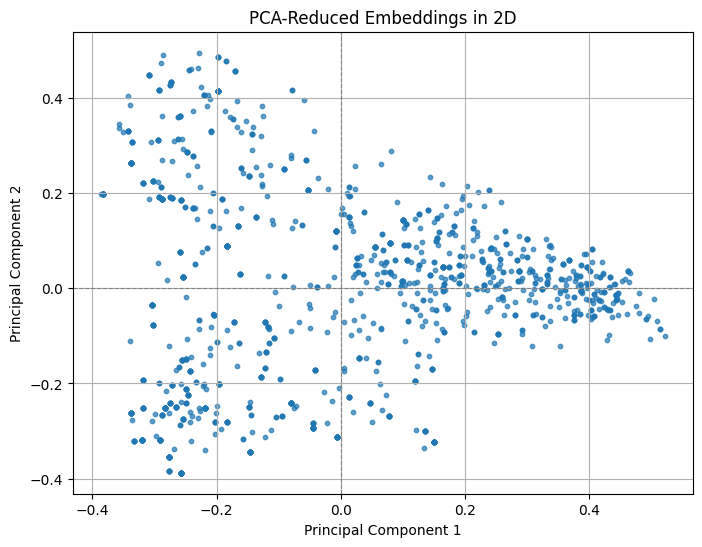

In [4]:
# create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.7, s=10)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA-Reduced Embeddings in 2D')

plt.grid(True)
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.8, linestyle='--')

plt.show()

To be able to discover the clustering behavior of the LLMs' embedding vectors, we color these data points by their original model and visualize each groups variance in 2D via the eclipse of the same color.

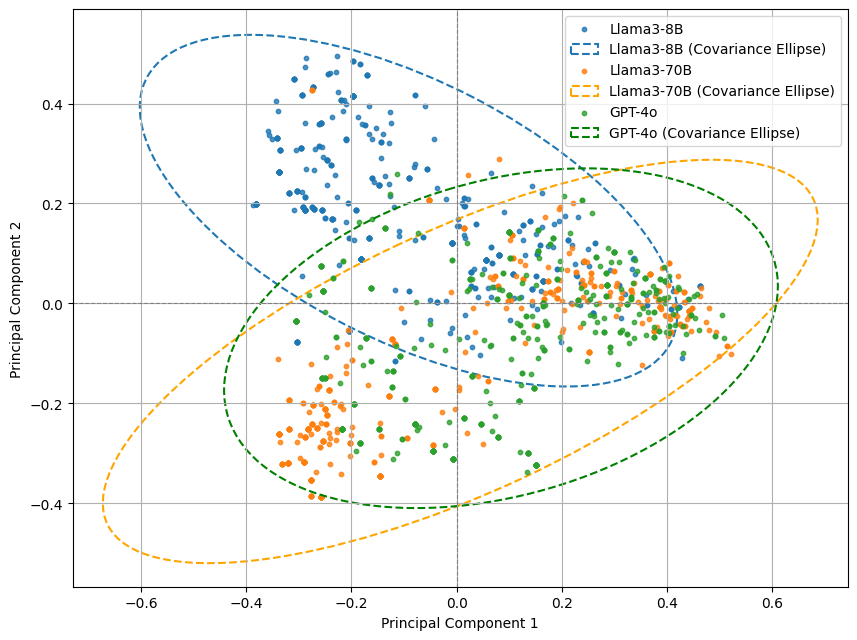

In [23]:
plt.figure(figsize=(10, 7.5))

eclipse_colors = ["tab:blue", "orange", "green"]
for i, label in enumerate(("Llama3-8B", "Llama3-70B", "GPT-4o")):
    slice_start = int(i * reduced_data.shape[0] / 3)
    slice_end = int(slice_start + reduced_data.shape[0] / 3)
    data = reduced_data[slice_start:slice_end, :]

    # Scatter the data points
    plt.scatter(
        data[:, 0], 
        data[:, 1], 
        label=label,  # Add label for the legend
        alpha=0.8, 
        s=10
    )
    
    # Calculate the mean and covariance matrix of the group
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)

    # Generate an ellipse based on the Mahalanobis distance
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Calculate the angle of the ellipse
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

    # Scaling for the ellipse (e.g., 95% confidence interval)
    chisq_val = 5.991  # 95% confidence for 2D
    width = 2 * np.sqrt(chisq_val * eigenvalues[0])
    height = 2 * np.sqrt(chisq_val * eigenvalues[1])

    # Add ellipse to the plot
    ellipse = Ellipse(
        xy=mean,
        width=width,
        height=height,
        angle=angle,
        edgecolor=eclipse_colors[i],
        facecolor='none',
        linestyle='--',
        linewidth=1.5,
        label=f'{label} (Covariance Ellipse)'
    )
    plt.gca().add_patch(ellipse)

plt.legend(loc="best")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.8, linestyle='--')
plt.show()